# Question 1 Train a CNN on CIFAR-10 with specified params

## Checking Avilable GPU

In [1]:
!nvidia-smi

Mon Feb 13 04:53:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   47C    P8    32W / 350W |    182MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [2]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
    import torchmetrics
except:
    !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

## device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Dataset with pytorch

### Downloading Dataset

In [4]:
from torchvision import transforms

# for simple conversion to grayscale and then to tensor
image_train_trasform_simple = transforms.Compose(
        [
                # transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()
        ]
)

# for simple conversion to grayscale + augmentation and then to tensor
image_train_trasform_augmented = transforms.Compose(
        [
                # transforms.Grayscale(num_output_channels=1),
                transforms.RandomRotation(10), # as mentioned in the question paper
                transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.01, 0.2)), # as mentioned in the question paper
                transforms.ToTensor()
        ]
)

image_test_trasform = transforms.Compose(
        [
                # transforms.Grayscale(num_output_channels=1),
                # no need to apply in test dataset
                transforms.ToTensor()
        ]
)

# plain dataset
train_dataset_original = torchvision.datasets.CIFAR10(
        root = 'data/',
        download = True,
        train = True,
        transform = image_train_trasform_simple
)

# augmented dataset
train_dataset_augmented = torchvision.datasets.CIFAR10(
        root = 'data/',
        download = True,
        train = True,
        transform = image_train_trasform_augmented
)

train_dataset_all_classes = torch.utils.data.ConcatDataset([train_dataset_original, train_dataset_augmented])

# removing non-required classes
final_subset = []
for idx,data in enumerate(train_dataset_all_classes):
  if data[1] in [0,2,4,6,8]: # specific classes, mentioned in the paper.
    final_subset.append(idx)

train_dataset = torch.utils.data.Subset(train_dataset_all_classes,final_subset)

# test dataset
test_dataset_all_classes = torchvision.datasets.CIFAR10(
        root = 'data/',
        download = True,
        train = False,
        transform = image_test_trasform
)

# removing non-required classes
final_subset = []
for idx,data in enumerate(test_dataset_all_classes):
  if data[1] in [0,2,4,6,8]: # specific classes, mentioned in the paper.
    final_subset.append(idx)

test_dataset = torch.utils.data.Subset(test_dataset_all_classes,final_subset)


# train_dataset_original, train_dataset_augmented ,test_dataset
train_dataset, test_dataset

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(<torch.utils.data.dataset.Subset at 0x7fb1e60f1ba0>,
 <torch.utils.data.dataset.Subset at 0x7fb2f84c2380>)

In [5]:
# print("len of train dataset all class",len(train_dataset_all_classes),"5 class",len(train_dataset))
# print("len of test dataset",len(test_dataset_all_classes),"5 class",len(test_dataset))

### Vis. dataset (train dataset)

In [6]:
# randomly ploting image samples from the grayscale dataset
def visualization(dataset):
  labels_map = dataset.class_to_idx # getting class -> index map
  labels_map = dict(map(reversed, labels_map.items())) # inverting dict
  # print(labels_map)

  figure = plt.figure(figsize=(8, 8)) # fixing plotsize
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)) # randomely selecting one image sample from the image index
      img, label = dataset[sample_idx] # getting image and label of selected index
      # sub plot code
      figure.add_subplot(rows, cols, i) 
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.permute(1,2,0)) # NOTE:- Color map is gray because we're converting imgae to grayscale / permute is used to change the channel order
      # sub plot code ends
  plt.show()

			 SAMPELS FORM Original Dataset


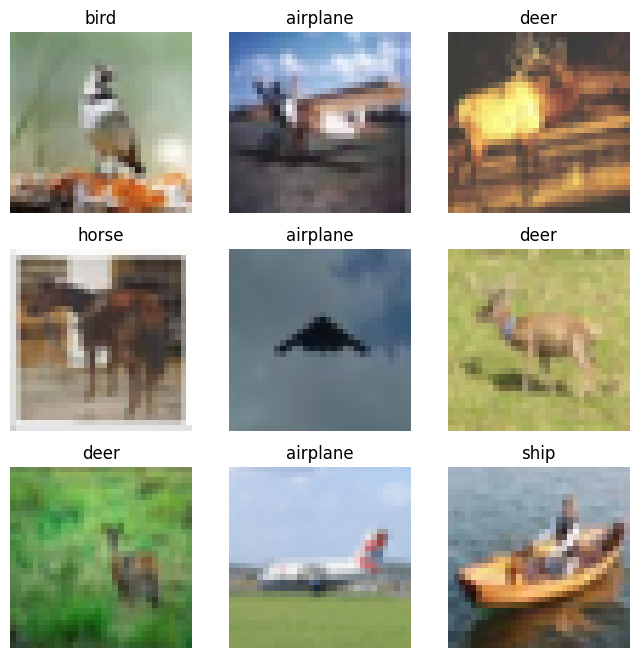


			 SAMPELS FORM Augmented Dataset


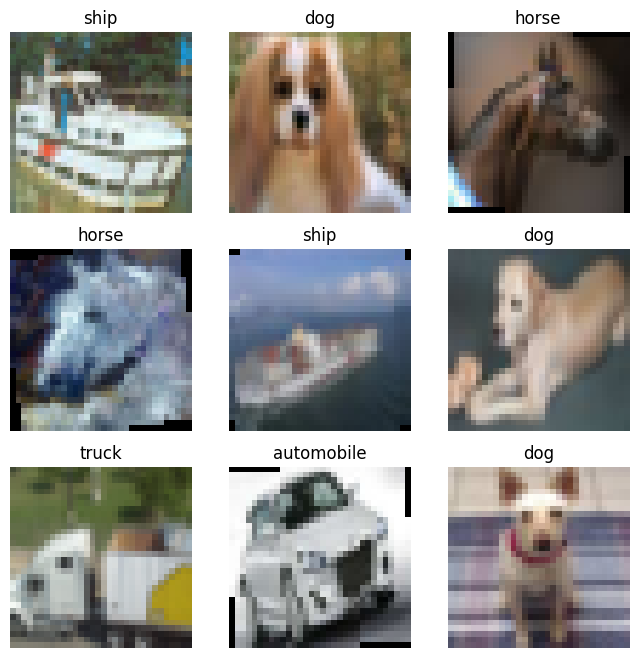

In [7]:
print("\t\t\t SAMPELS FORM Original Dataset")
visualization(train_dataset_original)
print()
print("\t\t\t SAMPELS FORM Augmented Dataset")
visualization(train_dataset_augmented)

### Converting dataset to dataloader

In [8]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() # no. of avilable cpu cores

# train dataloaders
train_dataloader = torch.utils.data.DataLoader(
        dataset = train_dataset,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS     
)

# train_dataloader_original = torch.utils.data.DataLoader(
#         dataset = train_dataset_original,
#         batch_size = BATCH_SIZE,
#         shuffle = True,
#         num_workers = NUM_WORKERS     
# )

# train_dataloader_augmented = torch.utils.data.DataLoader(
#         dataset = train_dataset_augmented,
#         batch_size = BATCH_SIZE,
#         shuffle = True,
#         num_workers = NUM_WORKERS     
# )

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
        dataset = test_dataset,
        batch_size = BATCH_SIZE,
        shuffle = False,
        num_workers = NUM_WORKERS     
)

print(f"Numbers of Batches in Train Dataloader Original: {len(train_dataloader)}")
# print(f"Numbers of Batches in Train Dataloader Augmented: {len(train_dataloader_augmented)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader Original: 1563
Numbers of Batches in Test Dataloader: 157


## Defining Model

In [9]:
class CustomArchNoCNN(nn.Module):
  def __init__(
      self,
    #   in_channels:int,
    #   hidden_units:int,
    #   out_channels:int,
      activation_funtion:nn.Module
      ) -> None:
    '''
    args:
      in_channels: input image shape
    #   hidden_units: numbers of filters
      out_channels: number of classes in the data
      actication_function: activation function of your choice
    '''
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features = 32*32*3,
            out_features = 1024
        ),
        activation_funtion,
        nn.Linear(
            in_features = 1024,
            out_features = 1024
        ),
        activation_funtion,
        nn.Linear(
            in_features = 1024,
            out_features = 1024
        ),
        activation_funtion
    )
    # applying xavier init. on weights
    for _ in self.block_1:
      try:
        nn.init.xavier_uniform_(_.weight)
      except:
        pass
        # print("No Weight params found!!!")
    
    self.fc_block = nn.Sequential(
        nn.Linear(
            in_features = 1024,
            out_features = 1024
        ),
        activation_funtion,
        nn.Linear(
            in_features = 1024,
            out_features = 10
            )
    )
    # applying xavier init. on weights
    # print(self.fc_block)
    nn.init.xavier_uniform_(self.fc_block[0].weight)
    nn.init.xavier_uniform_(self.fc_block[2].weight)
    
    # applying dropout 
    self.dropout = nn.Dropout(0.5)
  def forward(self,x:torch.Tensor):
    x = self.block_1(x)
    # print("conv_block_out shape:",x.shape)
    x = self.dropout(x)
    x = self.fc_block(x)
    # print("fc_block_out_ shape:",x.shape)
    return x

In [10]:
class CustomArch(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int,
      activation_funtion:nn.Module
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: numbers of filters
      out_channels: number of classes in the data
      actication_function: activation function of your choice
    '''
    super().__init__()
    self.conv_block = nn.Sequential(
        # Conv layer 1 with number of filter = hidden_units
        nn.Conv2d(
            in_channels = in_channels, 
            out_channels = hidden_units, 
            kernel_size = 3, # kernel size
            stride = 1,
            padding = 1
          ),
        activation_funtion,
        # Conv layer 2
        nn.Conv2d(
            in_channels = hidden_units, 
            out_channels = hidden_units, 
            kernel_size = 3, # kernel size
            stride = 1,
            padding = 1
        ),
        activation_funtion,
        # Conv layer 3
        nn.Conv2d(
            in_channels = hidden_units, 
            out_channels = hidden_units, 
            kernel_size = 3, # kernel size
            stride = 1,
            padding = 1
        ),
        activation_funtion,
        # Conv layer 4
        nn.Conv2d(
            in_channels = hidden_units, 
            out_channels = hidden_units, 
            kernel_size = 3, # kernel size
            stride = 1,
            padding = 1
        ),
        activation_funtion,
        # Conv layer 5
        nn.Conv2d(
            in_channels = hidden_units, 
            out_channels = hidden_units, 
            kernel_size = 3, # kernel size
            stride = 1,
            padding = 1
        ),
        activation_funtion,
        # Conv layer 6
        nn.Conv2d(
            in_channels = hidden_units, 
            out_channels = hidden_units, 
            kernel_size = 3, # kernel size
            stride = 1,
            padding = 1
        ),
        activation_funtion,
        # applying average pool
        nn.AvgPool2d(
            kernel_size = 2, # kernel size
            stride=2
        )
    )
    # applying xavier init. on weights
    for _ in self.conv_block:
      try:
        nn.init.xavier_uniform_(_.weight)
      except:
        pass
        # print("No Weight params found!!!")
    
    self.fc_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features = hidden_units * 16 * 16,
            out_features = 1024
        ),
        activation_funtion,
        nn.Linear(
            in_features = 1024,
            out_features = out_channels
            )
    )
    # applying xavier init. on weights
    # print(self.fc_block)
    nn.init.xavier_uniform_(self.fc_block[1].weight)
    nn.init.xavier_uniform_(self.fc_block[3].weight)
    
    # applying dropout 
    self.dropout = nn.Dropout(0.25)

  def forward(self,x:torch.Tensor):
    x = self.conv_block(x)
    # print("conv_block_out shape:",x.shape)
    x = self.dropout(x)
    x = self.fc_block(x)
    # print("fc_block_out_ shape:",x.shape)
    return x

## Train Test Fucntions

### training step

In [11]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str
    ):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train() # putting model in traing model

    train_loss, train_acc = 0, 0 # initlizing loss and acc. for the epoch

    for (X,y) in dataloader: # loop in batches
      X,y = X.to(device), y.to(device) # sending the data to target device
      # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

      # 1. forward pass
      y_pred_logits = model(X)

      # 2. calculate the loss
      # print("shape of logits and ground truth",y_pred_logits.shape,y.shape)
      loss = loss_fn(y_pred_logits, y)
      train_loss += loss.item()

      # 3. optimizer zero grad
      optimizer.zero_grad()

      # 4. loss backword
      loss.backward()

      # 5. optimizer step
      optimizer.step()
      

      # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
      # print("Model parms diff:")
      # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
      # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
      train_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss/len(dataloader), train_acc/len(dataloader)


### testing step

In [12]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str
    ):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval() # putting model in eval model

    test_loss, test_acc = 0, 0 # initlizing loss and acc. for the epoch

    with torch.inference_mode():
      for (X,y) in dataloader: # loop in batches
        X,y = X.to(device), y.to(device) # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.
    return test_loss/len(dataloader), test_acc/len(dataloader)

### traing loop

In [13]:
from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    # train_dataloader_augmented: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
  ):
  """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset with augmented data
      # train_dataloader_augmented (torch.utils.data.DataLoader): training dataloder from training dataset of augmented data
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
  """
  # 1. init. result dict
  result_dict = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # 2. loop in range epochs performs train and test steps on the model
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            acc_fn=acc_fn,
                                            optimizer=optimizer,
                                            device=device
                                          )
    
    # train_loss, train_acc = training_step(
    #                                         model=model,
    #                                         dataloader=train_dataloader_augmented,
    #                                         loss_fn=loss_fn,
    #                                         acc_fn=acc_fn,
    #                                         optimizer=optimizer,
    #                                         device=device
    #                                       )

    test_loss, test_acc = testing_step(
                                        model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        device=device
                                      )
  
  # 3. print out results
    print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )
    
  # 4. adding results to result_dict
    result_dict["train_loss"].append(train_loss)
    result_dict["train_acc"].append(train_acc)
    result_dict["test_loss"].append(test_loss)
    result_dict["test_acc"].append(test_acc)

  # 5. return result dict
  return result_dict

## Plot loss and acc. curves funtion

In [14]:
from typing import Dict,List

def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Desc:
      Plots curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {
              "train_loss": [...],
              "train_acc": [...],
              "test_loss": [...],
              "test_acc": [...]
            }
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

## Model Defination and training

In [15]:
class_names = test_dataloader.dataset.dataset.class_to_idx
print(class_names)
class_names = class_names.items()

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [16]:
model_0 = CustomArch(
    in_channels = 3,
    hidden_units = 12, # number of filters
    out_channels = len(class_names),
    activation_funtion = nn.ReLU(),
).to(device)

model_0

CustomArch(
  (conv_block): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [17]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip -q install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[32, 3, 32, 32]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
CustomArch                               [32, 10]                  --
├─Sequential: 1-1                        [32, 12, 16, 16]          6,540
│    └─Conv2d: 2-1                       [32, 12, 32, 32]          336
├─Sequential: 1-12                       --                        (recursive)
│    └─ReLU: 2-2                         [32, 12, 32, 32]          --
├─Sequential: 1-13                       --                        (recursive)
│    └─Conv2d: 2-3                       [32, 12, 32, 32]          1,308
├─Sequential: 1-12                       --                        (recursive)
│    └─ReLU: 2-4                         [32, 12, 32, 32]          --
├─Sequential: 1-13                       --                        (recursive)
│    └─Conv2d: 2-5                       [32, 12, 32, 32]          1,308
├─Sequential: 1-12                       --                        (recursive)
│    └─ReLU: 2-6              

In [18]:
# init. epochs
NUM_EPOCHS = 30

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=1e-3, weight_decay=1e-5)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0090 | train_acc: 0.2873 | test_loss: 0.7794 | test_acc: 0.3421
Epoch: 2 | train_loss: 0.6840 | train_acc: 0.3660 | test_loss: 0.6886 | test_acc: 0.3612
Epoch: 3 | train_loss: 0.5064 | train_acc: 0.4039 | test_loss: 0.6278 | test_acc: 0.3822
Epoch: 4 | train_loss: 0.3611 | train_acc: 0.4326 | test_loss: 0.7132 | test_acc: 0.3850
Epoch: 5 | train_loss: 0.2619 | train_acc: 0.4536 | test_loss: 0.6753 | test_acc: 0.3897
Epoch: 6 | train_loss: 0.2031 | train_acc: 0.4635 | test_loss: 0.7997 | test_acc: 0.3847
Epoch: 7 | train_loss: 0.1702 | train_acc: 0.4691 | test_loss: 0.8322 | test_acc: 0.3886
Epoch: 8 | train_loss: 0.1494 | train_acc: 0.4729 | test_loss: 0.8881 | test_acc: 0.3831
Epoch: 9 | train_loss: 0.1352 | train_acc: 0.4764 | test_loss: 0.7970 | test_acc: 0.3894
Epoch: 10 | train_loss: 0.1291 | train_acc: 0.4770 | test_loss: 0.8693 | test_acc: 0.3910
Epoch: 11 | train_loss: 0.1182 | train_acc: 0.4794 | test_loss: 0.9126 | test_acc: 0.3885
Epoch: 12 | train_l

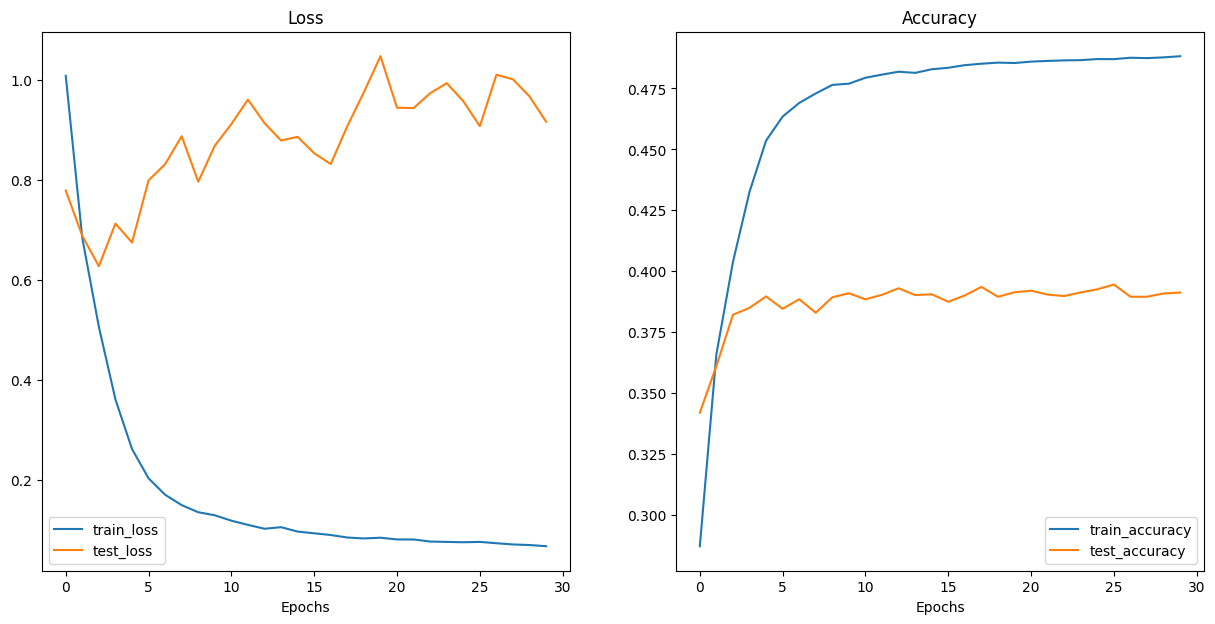

In [19]:
plot_loss_curves(model_0_results)

## ----------------------------------- model_exp. -----------------------------------

In [20]:
model_1 = CustomArchNoCNN(
    nn.ReLU(),
).to(device)
model_1

CustomArchNoCNN(
  (block_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): ReLU()
  )
  (fc_block): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
# init. epochs
NUM_EPOCHS = 30

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=1e-4, weight_decay=1e-5)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_1_results)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2229 | train_acc: 0.2419 | test_loss: 1.1269 | test_acc: 0.2700
Epoch: 2 | train_loss: 1.0815 | train_acc: 0.2778 | test_loss: 1.0253 | test_acc: 0.2858
Epoch: 3 | train_loss: 1.0128 | train_acc: 0.2942 | test_loss: 1.0099 | test_acc: 0.2883
Epoch: 4 | train_loss: 0.9555 | train_acc: 0.3060 | test_loss: 0.9903 | test_acc: 0.2982
Epoch: 5 | train_loss: 0.9122 | train_acc: 0.3161 | test_loss: 0.9925 | test_acc: 0.2988
Epoch: 6 | train_loss: 0.8705 | train_acc: 0.3258 | test_loss: 0.9187 | test_acc: 0.3193
Epoch: 7 | train_loss: 0.8283 | train_acc: 0.3330 | test_loss: 0.9192 | test_acc: 0.3192
Epoch: 8 | train_loss: 0.7909 | train_acc: 0.3425 | test_loss: 0.9213 | test_acc: 0.3163
Epoch: 9 | train_loss: 0.7526 | train_acc: 0.3492 | test_loss: 0.8988 | test_acc: 0.3244
Epoch: 10 | train_loss: 0.7206 | train_acc: 0.3568 | test_loss: 0.9345 | test_acc: 0.3202
Epoch: 11 | train_loss: 0.6822 | train_acc: 0.3638 | test_loss: 0.9354 | test_acc: 0.3267
Epoch: 12 | train_l

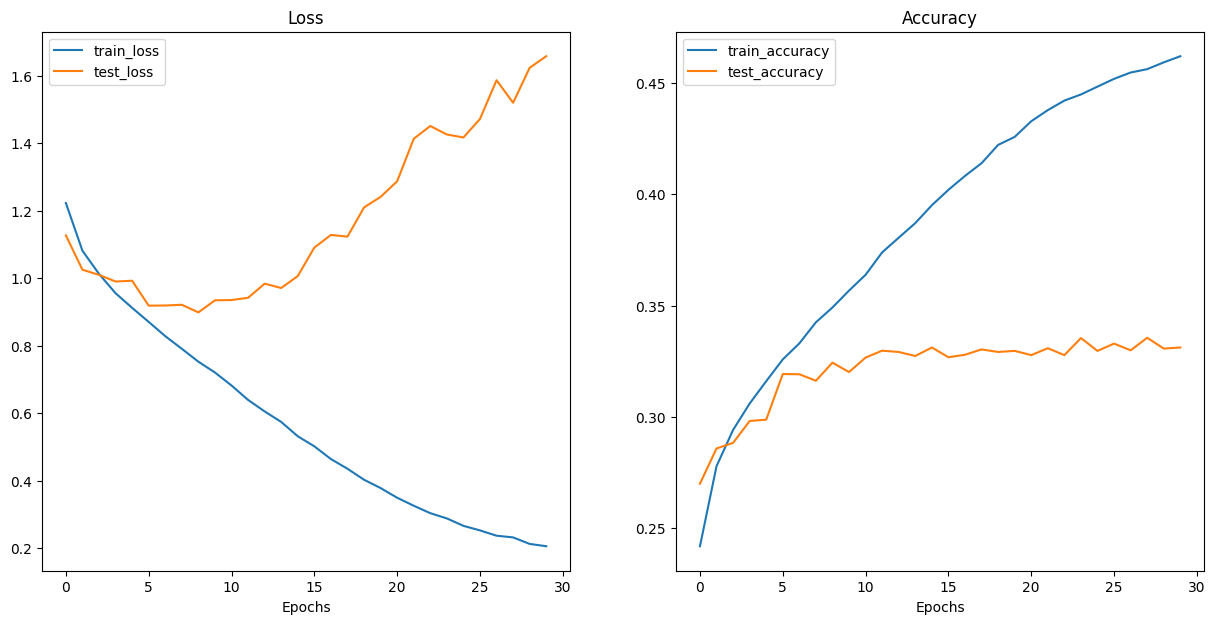

In [22]:
plot_loss_curves(model_1_results)